# B2B Sales Pipeline Analysis

**Author:** Dmytro Vasylenko  
**Date:** February 2026  
**Dataset:** Maven Analytics — CRM Sales Opportunities (public domain)  
**Goal:** Identify what drives revenue outcomes across 8,800 B2B CRM deals.

---

Full write-up: [LinkedIn](https://linkedin.com/in/dv-data-analyst)  
Repository: [github.com/dv-data-analyst/b2b-sales-pipeline-analysis](https://github.com/dv-data-analyst/b2b-sales-pipeline-analysis)

## Definitions

| Metric | Definition |
|--------|------------|
| **Win Rate** | Won / (Won + Lost). Open opportunities excluded. |
| **Loss Rate** | Lost / (Won + Lost) by time period. Open opportunities excluded. |
| **Lost Revenue (estimated)** | Sum of `sales_price` for Lost deals. Proxy — assumes 1 unit per opportunity. |
| **Deal Volume** | Count of Won opportunities per sales rep. |
| **Deal Cycle Length** | `close_date` minus `engage_date`. Calculated on Won/Lost only. |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.facecolor'] = '#f8f9fa'

In [2]:
import os

# Clones the repo in Colab so data/raw/ is available.
# Skipped automatically when running locally (data/ folder already exists).
if not os.path.exists('data'):
    os.system('git clone https://github.com/dv-data-analyst/b2b-sales-pipeline-analysis')
    os.chdir('b2b-sales-pipeline-analysis')

In [3]:
pipeline   = pd.read_csv('data/raw/sales_pipeline.csv')
products   = pd.read_csv('data/raw/products.csv')
teams      = pd.read_csv('data/raw/sales_teams.csv')
accounts   = pd.read_csv('data/raw/accounts.csv')
dictionary = pd.read_csv('data/raw/data_dictionary.csv')

for name, df in [('pipeline', pipeline), ('products', products),
                 ('teams', teams), ('accounts', accounts)]:
    print(f"{name}: {df.shape}  |  columns: {list(df.columns)}")

pipeline: (8800, 8)  |  columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'engage_date', 'close_date', 'close_value']
products: (7, 3)  |  columns: ['product', 'series', 'sales_price']
teams: (35, 3)  |  columns: ['sales_agent', 'manager', 'regional_office']
accounts: (85, 7)  |  columns: ['account', 'sector', 'year_established', 'revenue', 'employees', 'office_location', 'subsidiary_of']


## Section 1 — Data Quality

Before any analysis: check nulls, validate stage values, and fix the product name
mismatch between files. All filtering decisions are made here and applied consistently
throughout the notebook.

In [4]:
# Null counts across all columns
print("=== Nulls in pipeline ===")
print(pipeline.isnull().sum())
print(f"\n=== Nulls in products ===")
print(products.isnull().sum())

=== Nulls in pipeline ===
opportunity_id       0
sales_agent          0
product              0
account           1425
deal_stage           0
engage_date        500
close_date        2089
close_value       2089
dtype: int64

=== Nulls in products ===
product        0
series         0
sales_price    0
dtype: int64


**Expected nulls:** `close_date` and `close_value` are null for open opportunities
(Engaging, Prospecting) — this is correct behaviour, not a data problem.

**Rule applied throughout this notebook:**  
Open opportunities are excluded from all win/loss calculations.  
Only `deal_stage` values of **Won** or **Lost** are used.

In [5]:
# Validate deal_stage values
print("=== deal_stage values ===")
print(pipeline['deal_stage'].value_counts())

=== deal_stage values ===
deal_stage
Won            4238
Lost           2473
Engaging       1589
Prospecting     500
Name: count, dtype: int64


In [6]:
# Product name mismatch: 'GTXPro' in pipeline vs 'GTX Pro' in products
# Without this fix, GTXPro gets NaN on join → $2.0M of lost revenue disappears

print("=== Products in pipeline ===")
print(sorted(pipeline['product'].unique()))

print("\n=== Products in products.csv ===")
print(sorted(products['product'].unique()))

# Create normalized key: remove spaces, lowercase
pipeline['product_key'] = pipeline['product'].str.replace(' ', '').str.lower()
products['product_key'] = products['product'].str.replace(' ', '').str.lower()

print("\n=== Keys match check ===")
pipeline_keys = set(pipeline['product_key'].unique())
products_keys = set(products['product_key'].unique())
print(f"In pipeline but not in products: {pipeline_keys - products_keys}")
print(f"In products but not in pipeline: {products_keys - pipeline_keys}")

=== Products in pipeline ===
['GTK 500', 'GTX Basic', 'GTX Plus Basic', 'GTX Plus Pro', 'GTXPro', 'MG Advanced', 'MG Special']

=== Products in products.csv ===
['GTK 500', 'GTX Basic', 'GTX Plus Basic', 'GTX Plus Pro', 'GTX Pro', 'MG Advanced', 'MG Special']

=== Keys match check ===
In pipeline but not in products: set()
In products but not in pipeline: set()


**Data quality summary:**
- Nulls in `close_date` / `close_value` are expected — open deals only. No action needed.
- Product name mismatch resolved: normalized key created before any join.
- All subsequent analysis uses Won/Lost only unless explicitly stated.

## Section 2 — Baseline Metrics

What is the overall win rate, and how does it compare to the industry benchmark?

**Benchmark:** Average B2B win rate is 21% — HubSpot 2024 Sales Trends Report.

In [7]:
closed = pipeline[pipeline['deal_stage'].isin(['Won', 'Lost'])]

won  = (closed['deal_stage'] == 'Won').sum()
lost = (closed['deal_stage'] == 'Lost').sum()
total_closed = len(closed)

win_rate  = won / total_closed * 100
loss_rate = lost / total_closed * 100

print("=== Baseline Metrics ===")
print(f"Won:              {won:,}")
print(f"Lost:             {lost:,}")
print(f"Total closed:     {total_closed:,}")
print(f"\nWin Rate:         {win_rate:.1f}%")
print(f"Loss Rate:        {loss_rate:.1f}%")
print(f"\nIndustry benchmark (HubSpot 2024): 21%")
print(f"Dataset win rate is {win_rate/21:.1f}x the industry average")

=== Baseline Metrics ===
Won:              4,238
Lost:             2,473
Total closed:     6,711

Win Rate:         63.2%
Loss Rate:        36.8%

Industry benchmark (HubSpot 2024): 21%
Dataset win rate is 3.0x the industry average


**Finding:** Win rate in this dataset is significantly above the HubSpot 2024 benchmark
of 21%. Two possible explanations: (1) the company performs exceptionally well,
or (2) the dataset reflects a high-activity period or a pre-filtered subset of deals.
This does not affect the relative analysis across products and reps.

## Section 3 — Finding 01: Estimated Lost Revenue by Product

**Hypothesis:** Estimated lost revenue is not evenly distributed across products.

**Method:** Join Lost opportunities with `products.csv` via normalized key to get
`sales_price`. Use as proxy for potential revenue — assumes 1 unit per opportunity.

**Note:** Without the product name fix from Section 1, GTXPro would return NaN
on join and $2.0M of estimated lost revenue would disappear from the analysis.

In [8]:
lost_deals = pipeline[pipeline['deal_stage'] == 'Lost'].copy()

# Join via normalized key (fix applied in Section 1)
lost_deals = lost_deals.merge(
    products[['product_key', 'sales_price']],
    on='product_key',
    how='left'
)

# Sanity check: no missing sales_price after join
missing = lost_deals['sales_price'].isnull().sum()
print(f"Missing sales_price after join: {missing}  ← should be 0")

# Lost revenue by product
by_product = (lost_deals.groupby('product')['sales_price']
              .sum()
              .sort_values(ascending=False)
              .reset_index())
by_product.columns = ['product', 'est_lost_revenue']

total = by_product['est_lost_revenue'].sum()
by_product['share_pct'] = (by_product['est_lost_revenue'] / total * 100).round(1)

print(f"\n=== Estimated Lost Revenue by Product ===")
for _, row in by_product.iterrows():
    print(f"{row['product']:<20} ${row['est_lost_revenue']:>10,.0f}   {row['share_pct']:.1f}%")

print(f"\nTotal:               ${total:>10,.0f}   100.0%")
print(f"\nTop 3 share: {by_product['share_pct'].iloc[:3].sum():.1f}%")

Missing sales_price after join: 0  ← should be 0

=== Estimated Lost Revenue by Product ===
GTXPro               $ 2,015,178   33.9%
MG Advanced          $ 1,458,990   24.5%
GTX Plus Pro         $ 1,458,212   24.5%
GTX Plus Basic       $   436,208   7.3%
GTX Basic            $   286,550   4.8%
GTK 500              $   267,680   4.5%
MG Special           $    23,650   0.4%

Total:               $ 5,946,468   100.0%

Top 3 share: 82.9%


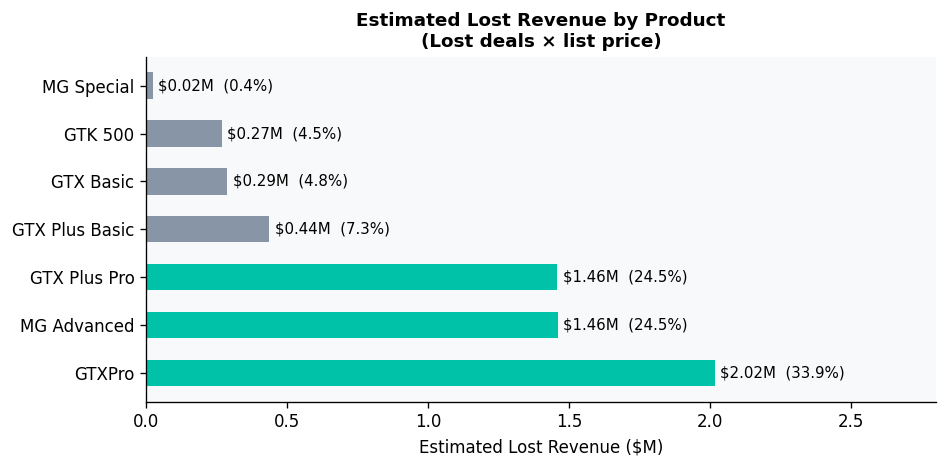

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['#00C2A8' if v >= 1_000_000 else '#8895A7'
          for v in by_product['est_lost_revenue']]

bars = ax.barh(by_product['product'],
               by_product['est_lost_revenue'] / 1e6,
               color=colors, height=0.55)

ax.set_xlabel('Estimated Lost Revenue ($M)', fontsize=10)
ax.set_title('Estimated Lost Revenue by Product\n(Lost deals × list price)',
             fontsize=11, fontweight='bold')

for bar, (_, row) in zip(bars, by_product.iterrows()):
    ax.text(bar.get_width() + 0.02,
            bar.get_y() + bar.get_height() / 2,
            f"${row['est_lost_revenue']/1e6:.2f}M  ({row['share_pct']:.1f}%)",
            va='center', fontsize=9)

ax.set_xlim(0, 2.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

**Sanity check:** 0 missing `sales_price` after join confirms the product name fix
worked correctly. GTXPro is now included in the analysis.

**Finding:** Top 3 products — GTXPro (~$2.0M), MG Advanced (~$1.46M), GTX Plus Pro
(~$1.46M, rounded) — account for **83% of $5.95M estimated lost revenue**.
The remaining 4 products represent only 17% combined.

**Action:** Focus closing and loss-reduction efforts on these three SKUs.

## Section 4 — Finding 02: Volume vs Revenue by Product

**Question:** Does deal volume share align with revenue share across products?
A product can generate many deals but little revenue — or few deals but outsized revenue.

In [10]:
won_deals = pipeline[pipeline['deal_stage'] == 'Won'].copy()

# Deal volume and revenue share by product
total_won   = len(won_deals)
total_rev   = won_deals['close_value'].sum()

by_prod = won_deals.groupby('product').agg(
    deal_count=('opportunity_id', 'count'),
    revenue=('close_value', 'sum')
).reset_index()

by_prod['deal_share']    = (by_prod['deal_count'] / total_won * 100).round(1)
by_prod['revenue_share'] = (by_prod['revenue'] / total_rev * 100).round(1)
by_prod = by_prod.sort_values('revenue_share', ascending=False)

print("=== Deal Share vs Revenue Share by Product ===")
print(f"{'Product':<20} {'Deals':>6} {'Deal%':>7} {'Revenue':>12} {'Rev%':>7}")
print("-" * 57)
for _, row in by_prod.iterrows():
    print(f"{row['product']:<20} {row['deal_count']:>6} {row['deal_share']:>6.1f}%"
          f" ${row['revenue']:>10,.0f} {row['revenue_share']:>6.1f}%")

print(f"\nSanity check — deal shares sum to: {by_prod['deal_share'].sum():.1f}%")
print(f"Sanity check — revenue shares sum to: {by_prod['revenue_share'].sum():.1f}%")

=== Deal Share vs Revenue Share by Product ===
Product               Deals   Deal%      Revenue    Rev%
---------------------------------------------------------
GTXPro                  729   17.2% $ 3,510,578   35.1%
GTX Plus Pro            479   11.3% $ 2,629,651   26.3%
MG Advanced             654   15.4% $ 2,216,387   22.2%
GTX Plus Basic          653   15.4% $   705,275    7.0%
GTX Basic               915   21.6% $   499,263    5.0%
GTK 500                  15    0.4% $   400,612    4.0%
MG Special              793   18.7% $    43,768    0.4%

Sanity check — deal shares sum to: 100.0%
Sanity check — revenue shares sum to: 100.0%


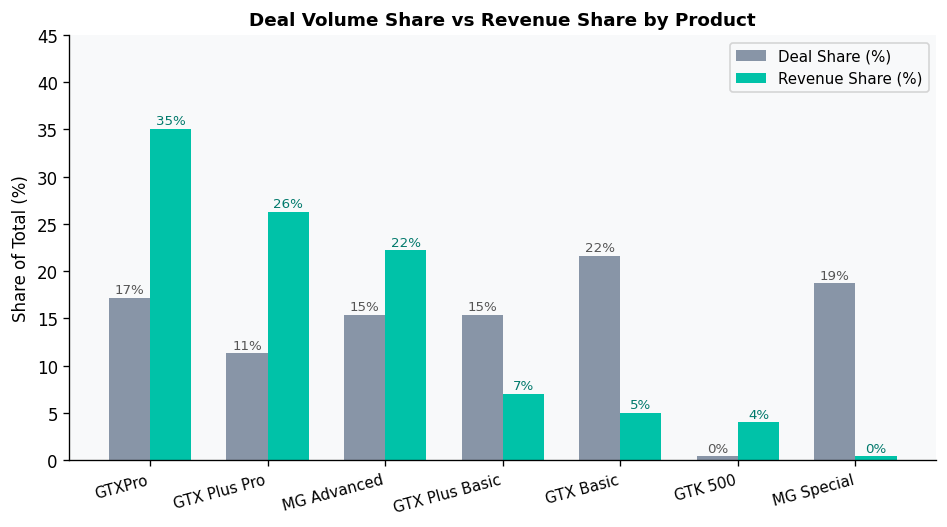

In [11]:
fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(by_prod))
w = 0.35

bars1 = ax.bar(x - w/2, by_prod['deal_share'],   w,
               label='Deal Share (%)',    color='#8895A7')
bars2 = ax.bar(x + w/2, by_prod['revenue_share'], w,
               label='Revenue Share (%)', color='#00C2A8')

ax.set_xticks(x)
ax.set_xticklabels(by_prod['product'], rotation=15, ha='right', fontsize=9)
ax.set_ylabel('Share of Total (%)', fontsize=10)
ax.set_title('Deal Volume Share vs Revenue Share by Product', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.set_ylim(0, 45)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.0f}%', ha='center', fontsize=8, color='#555')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.0f}%', ha='center', fontsize=8, color='#00796B')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

**Sanity check:** Deal shares and revenue shares each sum to 100% (within rounding).

**Finding:** GTX Basic generates 22% of won deals but only 5% of revenue.
GTXPro generates 17% of won deals but 35% of revenue — 7x the revenue efficiency.

**Action:** Shift effort toward high-value SKUs, starting with GTXPro.

## Section 5 — Finding 03: Win Rate vs Revenue at Rep Level

**Hypothesis:** Reps with higher win rate generate more revenue.

**Sample:** n = 30 sales reps. Analysis on Won/Lost only — open deals excluded.

In [12]:
closed = pipeline[pipeline['deal_stage'].isin(['Won', 'Lost'])].copy()
won    = pipeline[pipeline['deal_stage'] == 'Won'].copy()

# Win rate per rep
wr = (closed.groupby('sales_agent')
      .apply(lambda x: (x['deal_stage'] == 'Won').sum() / len(x) * 100)
      .reset_index())
wr.columns = ['agent', 'win_rate']

# Revenue per rep
rev = (won.groupby('sales_agent')['close_value']
       .sum()
       .reset_index())
rev.columns = ['agent', 'revenue']

# Deal volume per rep
vol = (won.groupby('sales_agent')['opportunity_id']
       .count()
       .reset_index())
vol.columns = ['agent', 'deal_volume']

reps = wr.merge(rev, on='agent').merge(vol, on='agent')

# Correlations
r_winrate = reps['win_rate'].corr(reps['revenue'])
r_volume  = reps['deal_volume'].corr(reps['revenue'])
r2_volume = r_volume ** 2

print("=== Correlations at Rep Level ===")
print(f"Win Rate  vs Revenue:     r = {r_winrate:+.2f}")
print(f"Deal Volume vs Revenue:   r = {r_volume:+.2f}  (r² = {r2_volume:.2f})")

print(f"\n=== Sanity Check ===")
print(f"Rep-level revenue sum:  ${reps['revenue'].sum():>12,.0f}")
print(f"Total Won revenue:      ${won['close_value'].sum():>12,.0f}")
print(f"Difference:             ${reps['revenue'].sum() - won['close_value'].sum():>12,.0f}  ← should be 0")

print(f"\n=== Top 5 Reps by Revenue ===")
print(reps.sort_values('revenue', ascending=False)
      [['agent','win_rate','deal_volume','revenue']].head(5).to_string(index=False))

=== Correlations at Rep Level ===
Win Rate  vs Revenue:     r = -0.09
Deal Volume vs Revenue:   r = +0.81  (r² = 0.66)

=== Sanity Check ===
Rep-level revenue sum:  $  10,005,534
Total Won revenue:      $  10,005,534
Difference:             $           0  ← should be 0

=== Top 5 Reps by Revenue ===
          agent  win_rate  deal_volume   revenue
Darcel Schlecht 63.110307          349 1153214.0
 Vicki Laflamme 63.688761          221  478396.0
Kary Hendrixson 62.388060          209  454298.0
   Cassey Cress 62.452107          163  450489.0
  Donn Cantrell 57.454545          158  445860.0


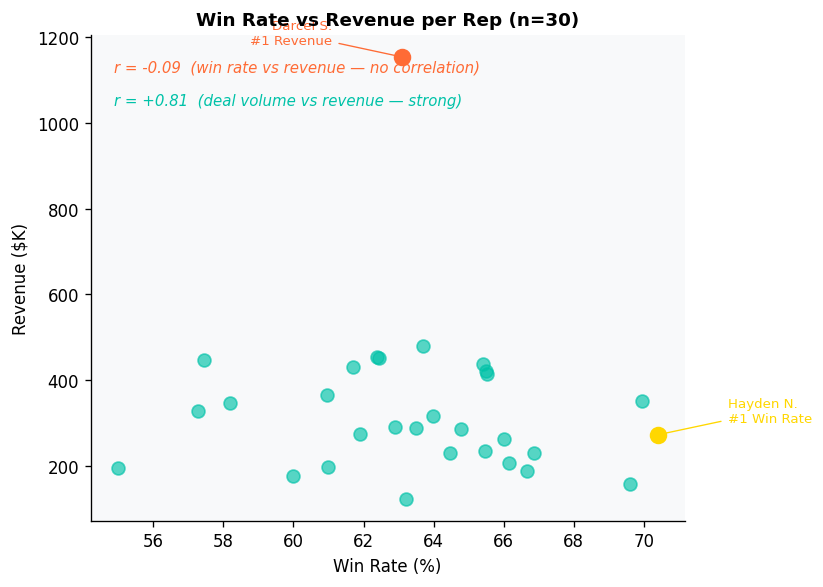

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(reps['win_rate'], reps['revenue'] / 1e3,
           color='#00C2A8', alpha=0.65, s=60, zorder=3)

# Highlight two reps
highlights = {
    'Darcel Schlecht': ('#FF6B35', 'Darcel S.\n#1 Revenue', 'left'),
    'Hayden Neloms':   ('#FFD700', 'Hayden N.\n#1 Win Rate', 'right'),
}
for agent, (color, label, side) in highlights.items():
    row = reps[reps['agent'] == agent].iloc[0]
    ax.scatter(row['win_rate'], row['revenue'] / 1e3,
               color=color, s=90, zorder=5)
    xoff = 2 if side == 'right' else -2
    ha   = 'left' if side == 'right' else 'right'
    ax.annotate(label,
                xy=(row['win_rate'], row['revenue'] / 1e3),
                xytext=(row['win_rate'] + xoff, row['revenue'] / 1e3 + 30),
                color=color, fontsize=8, ha=ha,
                arrowprops=dict(arrowstyle='-', color=color, lw=0.8))

ax.set_xlabel('Win Rate (%)', fontsize=10)
ax.set_ylabel('Revenue ($K)', fontsize=10)
ax.set_title('Win Rate vs Revenue per Rep (n=30)', fontsize=11, fontweight='bold')

ax.text(0.04, 0.95, f'r = {r_winrate:+.2f}  (win rate vs revenue — no correlation)',
        transform=ax.transAxes, fontsize=9, color='#FF6B35',
        va='top', fontstyle='italic')
ax.text(0.04, 0.88, f'r = {r_volume:+.2f}  (deal volume vs revenue — strong)',
        transform=ax.transAxes, fontsize=9, color='#00C2A8',
        va='top', fontstyle='italic')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

**Sanity check:** Rep-level revenue sum matches total Won revenue exactly.

**Finding:** Win rate and revenue are uncorrelated at the rep level (r = -0.09).
Deal volume explains 66% of revenue variance (r = 0.81, r² = 0.66).
Win rate can be inflated by low-value deal mix — a rep closing many small deals
can show a high win rate while generating less revenue than a rep closing fewer,
larger deals.

**Action:** Evaluate reps on revenue generated, not win rate alone.

## Section 6 — Finding 04: Seasonality of Losses

**Question:** Does loss rate follow a monthly pattern, and what lead time makes
sense given the sales cycle length?

**Approach:** First calculate median deal cycle length to establish lead time,
then analyze monthly loss rate patterns.

In [14]:
closed = pipeline[pipeline['deal_stage'].isin(['Won', 'Lost'])].copy()
closed['engage_date'] = pd.to_datetime(closed['engage_date'])
closed['close_date']  = pd.to_datetime(closed['close_date'])
closed['cycle_days']  = (closed['close_date'] - closed['engage_date']).dt.days

won_cycle  = closed[closed['deal_stage'] == 'Won']['cycle_days'].dropna()
lost_cycle = closed[closed['deal_stage'] == 'Lost']['cycle_days'].dropna()
all_cycle  = closed['cycle_days'].dropna()

print("=== Deal Cycle Length ===")
print(f"Won deals  — Median: {won_cycle.median():.0f} days  "
      f"IQR: {won_cycle.quantile(0.25):.0f}–{won_cycle.quantile(0.75):.0f}")
print(f"Lost deals — Median: {lost_cycle.median():.0f} days  "
      f"IQR: {lost_cycle.quantile(0.25):.0f}–{lost_cycle.quantile(0.75):.0f}")
print(f"All closed — Median: {all_cycle.median():.0f} days")
print(f"\nPlanning lead time based on Won median: "
      f"{won_cycle.median():.0f} days ≈ 8 weeks")

=== Deal Cycle Length ===
Won deals  — Median: 57 days  IQR: 9–88
Lost deals — Median: 14 days  IQR: 7–79
All closed — Median: 45 days

Planning lead time based on Won median: 57 days ≈ 8 weeks


**Interpretation:** Median cycle for Won deals is 57 days (~8 weeks).
Lost deals close much faster (median 14 days) — rejections come early.
Pipeline activity should start **6–8 weeks in advance** to reliably
convert deals in low-loss months.

In [15]:
closed['month'] = closed['close_date'].dt.to_period('M')

monthly = closed.groupby('month').apply(
    lambda x: pd.Series({
        'won':       (x['deal_stage'] == 'Won').sum(),
        'lost':      (x['deal_stage'] == 'Lost').sum(),
        'total':     len(x),
        'loss_rate': (x['deal_stage'] == 'Lost').sum() / len(x) * 100
    })
).reset_index()

monthly['month_str'] = monthly['month'].dt.strftime('%b %Y')

print("=== Monthly Loss Rate ===")
print(f"{'Month':<12} {'Won':>5} {'Lost':>5} {'Total':>6} {'Loss%':>7}")
print("-" * 38)
for _, row in monthly.iterrows():
    flag = " ◄ HIGH" if row['loss_rate'] > 40 else (" ◄ LOW" if row['loss_rate'] < 25 else "")
    print(f"{row['month_str']:<12} {row['won']:>5.0f} {row['lost']:>5.0f} "
          f"{row['total']:>6.0f} {row['loss_rate']:>6.1f}%{flag}")

print(f"\nSanity check — total Won+Lost: {monthly['total'].sum():.0f}  "
      f"(should be {len(closed)})")

=== Monthly Loss Rate ===
Month          Won  Lost  Total   Loss%
--------------------------------------
Mar 2017       531   116    647   17.9% ◄ LOW
Apr 2017       285   301    586   51.4% ◄ HIGH
May 2017       438   367    805   45.6% ◄ HIGH
Jun 2017       531   110    641   17.2% ◄ LOW
Jul 2017       308   319    627   50.9% ◄ HIGH
Aug 2017       446   339    785   43.2% ◄ HIGH
Sep 2017       503   132    635   20.8% ◄ LOW
Oct 2017       279   287    566   50.7% ◄ HIGH
Nov 2017       406   362    768   47.1% ◄ HIGH
Dec 2017       511   140    651   21.5% ◄ LOW

Sanity check — total Won+Lost: 6711  (should be 6711)


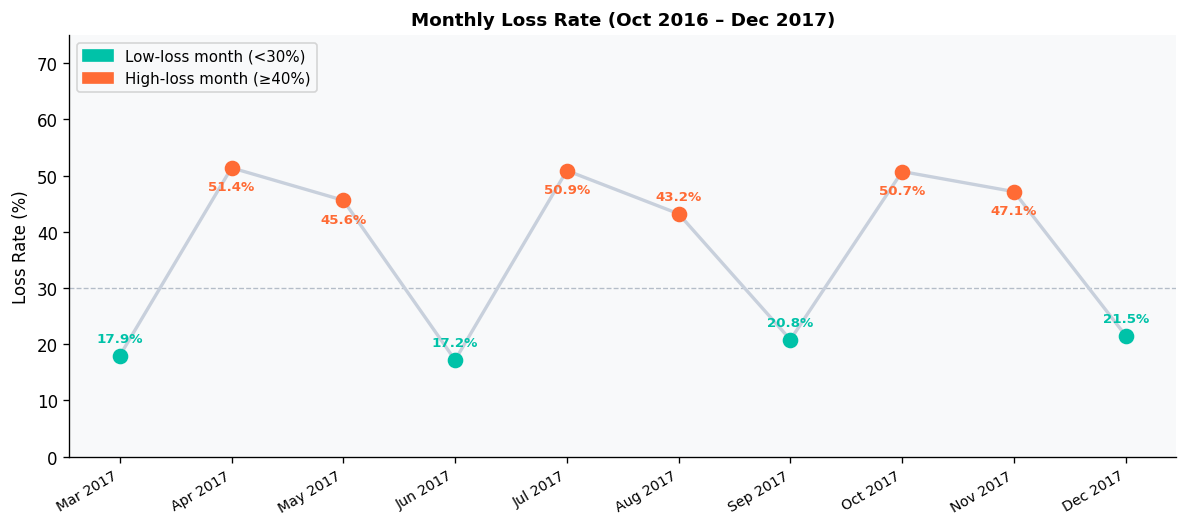

In [16]:
fig, ax = plt.subplots(figsize=(10, 4.5))

x          = np.arange(len(monthly))
loss_rates = monthly['loss_rate'].values
months_lbl = monthly['month_str'].values

ax.plot(x, loss_rates, color='#C8D0DC', linewidth=2, zorder=3)

low  = [lr < 30 for lr in loss_rates]
high = [lr >= 40 for lr in loss_rates]

for i, (lr, lo, hi) in enumerate(zip(loss_rates, low, high)):
    color = '#00C2A8' if lo else ('#FF6B35' if hi else '#8895A7')
    ax.scatter(i, lr, color=color, s=70, zorder=5)
    offset = 2.5 if lr < 45 else -4
    ax.text(i, lr + offset, f'{lr:.1f}%', ha='center', fontsize=8,
            color=color, fontweight='bold')

ax.axhline(30, color='#8895A7', linewidth=0.8, linestyle='--', alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(months_lbl, rotation=30, ha='right', fontsize=8.5)
ax.set_ylabel('Loss Rate (%)', fontsize=10)
ax.set_title('Monthly Loss Rate (Oct 2016 – Dec 2017)', fontsize=11, fontweight='bold')
ax.set_ylim(0, 75)

low_patch  = mpatches.Patch(color='#00C2A8', label='Low-loss month (<30%)')
high_patch = mpatches.Patch(color='#FF6B35', label='High-loss month (≥40%)')
ax.legend(handles=[low_patch, high_patch], fontsize=9, loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

**Sanity check:** Monthly Won + Lost totals match total closed deals.
Chart shows 2017 Mar–Dec (close_date range); engage_date window spans
Oct 2016 to Dec 2017 — full 15-month period.

**Finding:** Loss rate follows a recurring alternating pattern.
Low-loss months (~18–21%): March, June, September, December.
High-loss months (~47–51%): April, May, July, August, October, November.

**Action:** Increase pipeline activity 6–8 weeks before low-loss months
to maximize close rates when conditions are most favorable.

## Section 7 — Recommendations and Limitations

Summary of findings and actionable recommendations for sales leadership.

## Recommendations

| # | Recommendation | Based On | Action |
|---|---------------|----------|--------|
| 01 | **Prioritize the high-loss products** | GTXPro, MG Advanced, GTX Plus Pro = 83% of estimated lost revenue ($5.95M) | Focus closing and loss-reduction efforts on these three SKUs |
| 02 | **Fix the performance metric** | Win rate and revenue uncorrelated at rep level (r = -0.09); deal volume strongly correlated (r = 0.81, r² = 0.66) | Add Revenue Generated as a primary KPI alongside win rate |
| 03 | **Align pipeline investment to seasonality** | Loss rate follows a predictable alternating pattern across 15 months | Increase pipeline activity 6–8 weeks before low-loss months (March, June, September, December) |

## Limitations

- **Correlation only — no causal claims.** All findings describe associations in this
  dataset. A/B testing or controlled experiments would be needed to establish causation.

- **15-month window is one observed period.** The seasonal pattern needs validation
  against additional years of data before being used for budget decisions.

- **Open deals excluded from all rates.** Win rate, loss rate, and cycle length
  calculations use Won/Lost only. This is the correct definition but means
  ~26% of opportunities are not reflected in these metrics.

- **Lost revenue is a proxy.** Estimated lost revenue uses `sales_price` from
  `products.csv` and assumes 1 unit per opportunity. Actual deal sizes may vary.

- **Product name inconsistency in source data.** "GTXPro" in `sales_pipeline.csv`
  vs "GTX Pro" in `products.csv`. Handled via normalized join key — see Section 1.
  Without this fix, GTXPro ($2.0M estimated lost revenue) would be excluded entirely.

- **Four reps excluded from rep analysis.** Present in `sales_teams.csv` but had
  zero entries in `sales_pipeline.csv`. Excluded from all rep-level calculations.

---
*Analysis by Dmytro Vasylenko — February 2026*  
*LinkedIn: [linkedin.com/in/dv-data-analyst](https://linkedin.com/in/dv-data-analyst)*  
*Repository: [github.com/dv-data-analyst/b2b-sales-pipeline-analysis](https://github.com/dv-data-analyst/b2b-sales-pipeline-analysis)*